In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import pprint as pp
import imp
import matplotlib.pyplot as plt
import networkx as nx
from nxpd import draw
import seaborn as sn

sn.set_context('notebook')

# Norway Pollutant Export model

This notebook illustrates the basic usage of a simple export coefficient model based loosely on [TEOTIL](https://brage.bibsys.no/xmlui/bitstream/handle/11250/214825/5914-2010_72dpi.pdf?sequence=1&isAllowed=y). The [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model_inputs.ipynb) described preparation of the input file for the new model, and the model code itself can be found [here](https://github.com/JamesSample/rid/blob/master/notebooks/nope.py). In addition, [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/simple_network_model.ipynb) provides a brief introduction to network graphs in Python.

Note that the model here is still pretty rough and will require further development and debugging before being applied in practice. The aim here is simply to investigate whether a TEOTIL-like model can be implemented easily in Python.

**Update 24/08/2017:** I have now added a function to make it easier to generate model input files for the RID programme. All the key datasets (discharge, point sources, agricultural land use coefficients etc.) must first be pre-processed and added to RESA2 - see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/prepare_teotil_inputs.ipynb) for details (although this can now be tidied up a lot, as I'm no longer planning to use TEOTIL).

In [12]:
# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

## 1. Generate input file

First, specify the key parameters of interest and paths to relevant datasets. The run `nope.make_rid_input_file`.

In [13]:
# Year of interest
year = 2015

# Parameters of interest
par_list = ['Tot-N', 'Tot-P']

# Folder containing NOPE data
nope_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\NOPE_Core_Input_Data')

# Ouput path for model file
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\nope_input_data_2015.csv')

# Make input file
df = nope.make_rid_input_file(year, engine, nope_fold, out_csv,
                              par_list=par_list)

## 2. Run model

The new model is very easy to run: ***either*** point it to the input CSV created above or pass in the returned dataframe directly, then call `nope.run_model()`. In the code below, we use `%%time` to measure the total runtime (reading the inputs and performing the network accumulation). Passing the dataframe directly is marginally faster, but obviously requires you to create the input file each time (which is slower than reading one that has already been created).

In [14]:
%%time
# Input file (see previous notebook)
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\nope_input_data_2015.csv')

# Run model
g = nope.run_nope(in_csv, par_list)

Wall time: 6.64 s


On my laptop, the new model takes around 5 seconds to process the data for N and P. Running TEOTIL for the same two parameters on the same machine takes approximately 8 hours, so the new model, without any optimisation, is more than 5000 times faster. This difference in performance opens up opportunities for improved testing and calibration, as well as making it much easier to use.

## 3. Explore output

### 3.1. Basic data access

The model returns a "network object", where each node in the network corresponds to a catchment. Each node has two data stores associated with it: one containing the `local` inputs from each specific regine catchment, and a second called `accum` which stores accumulated results (i.e. including upstream inputs and allowing for retention). These properties can be queried as follows:

In [15]:
# Get local data for catchment '001.1A40'
print 'Local data for "001.1A40":'
pp.pprint(g.node['001.1A40']['local'])
print ''

# Get accum data for catchment '001.1A40'
print 'Accumulated data for "001.1A40":'
pp.pprint(g.node['001.1A40']['accum'])

Local data for "001.1A40":
{'a_reg_km2': 12.37,
 'all_point_tot-n_tonnes': 0.4685274321110722,
 'all_point_tot-p_tonnes': 0.03543877277933409,
 'all_sources_tot-n_tonnes': 7.214525399626328,
 'all_sources_tot-p_tonnes': 0.307114100462701,
 'anth_diff_tot-n_tonnes': 3.5701360038325523,
 'anth_diff_tot-p_tonnes': 0.2234827326934844,
 'aqu_tot-n_tonnes': 0.0,
 'aqu_tot-p_tonnes': 0.0,
 'ind_tot-n_tonnes': 0.0,
 'ind_tot-p_tonnes': 0.0,
 'nat_diff_tot-n_tonnes': 3.175861963682704,
 'nat_diff_tot-p_tonnes': 0.04819259498988252,
 'q_reg_m3/s': 0.17025799299930944,
 'regine': '001.1A40',
 'regine_ned': '001.1A3',
 'ren_tot-n_tonnes': 0.0,
 'ren_tot-p_tonnes': 0.0,
 'runoff_mm/yr': 434.0546537773826,
 'spr_tot-n_tonnes': 0.4251067394581939,
 'spr_tot-p_tonnes': 0.03192887270161282,
 'trans_tot-n': 1.0,
 'trans_tot-p': 1.0}

Accumulated data for "001.1A40":
{'all_point_tot-n_tonnes': 1.1479107577605192,
 'all_point_tot-p_tonnes': 0.056055339968399724,
 'all_sources_tot-n_tonnes': 45.21662227831

### 3.2. Network diagrams

The model can create schematic diagrams upstream and downstream from any node. These can be annotated with any output value the user chooses. Note that if the user specifies "direct='up'", *the arrows on the schematic will point upstream*.

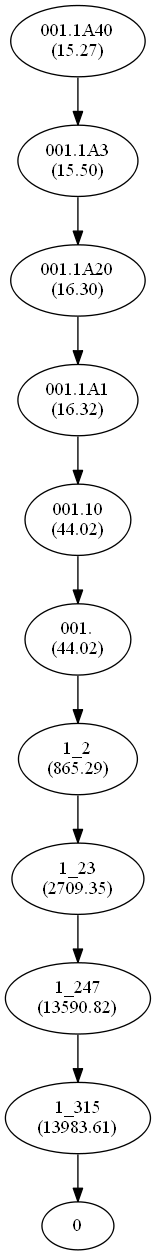

In [16]:
# Plot network labelled with accumulated flow
g2 = nope.plot_network(g, '001.1A40', direct='down', stat='accum', quant='q_m3/s')
draw(g2, show='ipynb')

### 3.3. Summary maps

The user can also choose `local` or `accum` and specify a parameter of interest to generate a simple map. Note that this can take a minute or so, as rendering the regine polygons is computationally intensive. Optionally, the data can be square-root transformed before plotting, and different colour schemes can be applied. The plot can also be saved as an image file by specifying the `plot_path`.

C:\Data\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Data\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


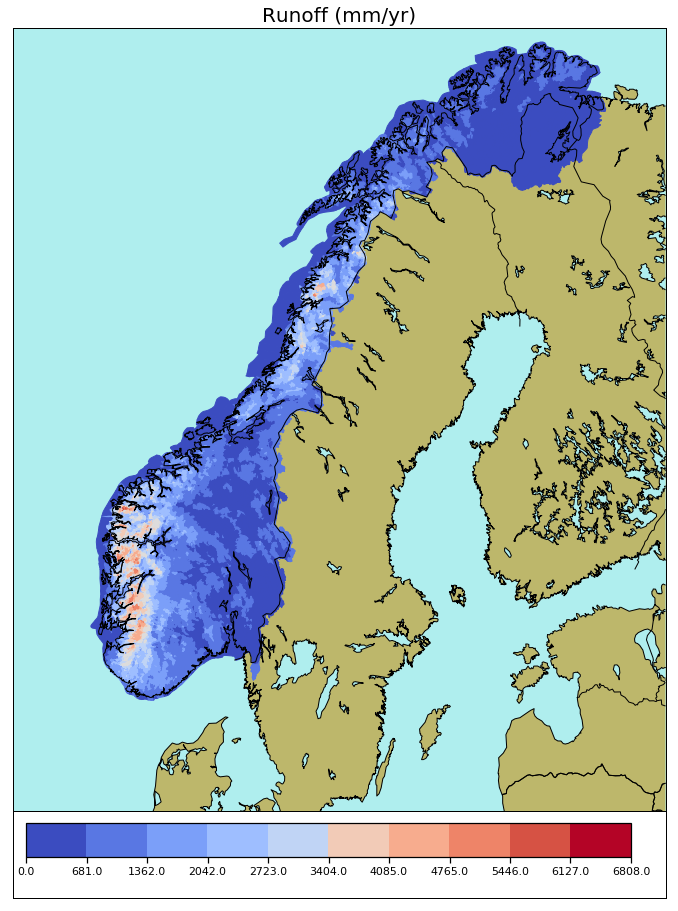

In [17]:
# Summary map of local runoff
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\PNG_Maps\runoff.png')

fig = nope.make_map(g, stat='local', quant='runoff_mm/yr', sqrt=False,
                    cmap='coolwarm', n_cats=10, plot_path=out_png)

### 3.4. Write results to CSV

The graph can be easily converted to CSV format for further analysis.

In [18]:
# Save results as csv
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\nope_results_2015.csv')
df = nope.model_to_dataframe(g, out_path=out_csv)

df.head()

,regine,regine_ned,accum_all_point_tot-n_tonnes,accum_all_point_tot-p_tonnes,accum_all_sources_tot-n_tonnes,accum_all_sources_tot-p_tonnes,accum_anth_diff_tot-n_tonnes,accum_anth_diff_tot-p_tonnes,accum_aqu_tot-n_tonnes,accum_aqu_tot-p_tonnes,...,local_nat_diff_tot-n_tonnes,local_nat_diff_tot-p_tonnes,local_q_reg_m3/s,local_ren_tot-n_tonnes,local_ren_tot-p_tonnes,local_runoff_mm/yr,local_spr_tot-n_tonnes,local_spr_tot-p_tonnes,local_trans_tot-n,local_trans_tot-p
0,001.222Z,001.2220,0.119378,0.009030,2.474535,0.083063,0.909652,0.056942,0.0,0.0,...,1.445505,0.017092,0.085473,0.0,0.0,434.054654,0.108315,0.008135,1.00,1.00
1,002.DGBZ,002.DGB0,0.000000,0.000000,6.429953,0.137348,0.000000,0.000000,0.0,0.0,...,6.628817,0.165480,0.989583,0.0,0.0,362.624732,0.000000,0.000000,0.97,0.83
2,123.A1Z,123.A12,0.489527,0.023622,16.176846,0.308573,11.190604,0.246177,0.0,0.0,...,5.551500,0.129247,0.636149,0.0,0.0,503.427803,0.450727,0.065091,0.81,0.30
3,212.FAC,212.FAB0,0.021639,0.000779,6.659930,0.068712,0.000000,0.000000,0.0,0.0,...,6.987675,0.089385,0.495119,0.0,0.0,287.234419,0.022777,0.001025,0.95,0.76
4,135.1AC,135.1AB,0.000000,0.000000,5.817805,0.060086,0.000000,0.000000,0.0,0.0,...,6.844476,0.143063,1.092563,0.0,0.0,2452.318429,0.000000,0.000000,0.85,0.42


## 4. Compare results to observed data

The new model is uncalibrated, so I don't expect it to be particularly accurate yet. However, because it is similar in design to TEOTIL and because TEOTIL *has* been previously calibrated, the output might not be too bad. Overall, I would expect the results to be similar to those produced by TEOTIL, but not necessarily the same as the observed values.

The easiest way to evaluate the output is therefore to link the new model results to those from TEOTIL for 2015. However, restructuring the TEOTIL output seems messy: most of the work is done in this Access database

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Rekonstruksjon\db1.mdb

and, even after looking at it for a while, I have absolutely no idea what's going on here!

A more rigourous test is to compare the model results to observed values. The code below reads the load estimates for 2015 for the sites where water chemistry is measured (i.e. the `RID_11` and `RID_36` stations). These observed loads are then compared to predictions from my new - but uncalibrated - model. 

**Note the log-log scale on the plots below due to large data ranges**

C:\Data\Anaconda2\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


47


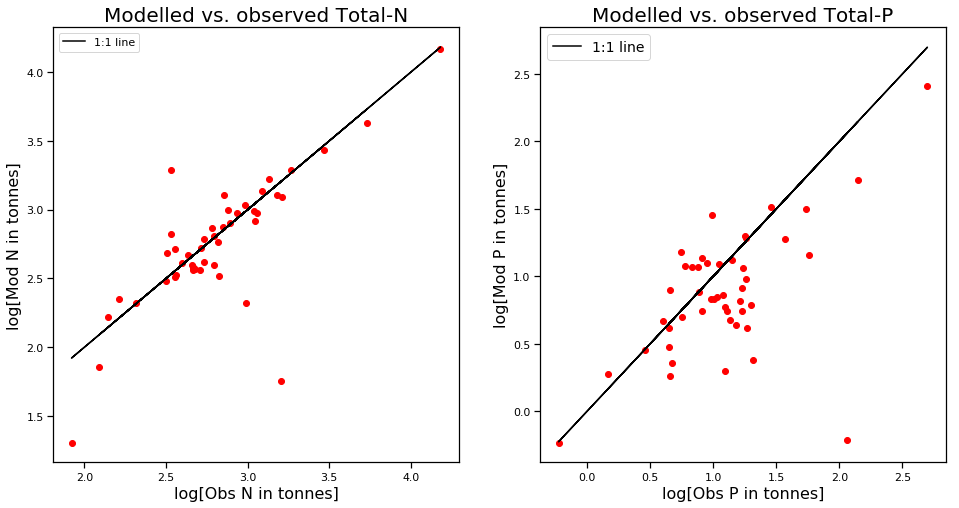

In [19]:
# Read station data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\rid_conc_and_loads_summaries_2016.xlsx')
stn_df = pd.read_excel(in_xlsx, sheetname='station_data')

# Consider just the RID_11 and RID_36 stations
stn_df = stn_df.query('rid_group != "rid_108"')

# Get just cols of interest
stn_df = stn_df[['station_id', 'station_code', 'station_name', 'nve_vassdrag_nr']]

# Read 2015 observed loads for N and P
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\Results\Loads_CSVs\loads_all_sites_2015.csv')
lds_df = pd.read_csv(in_csv, encoding='utf-8')
lds_df = lds_df[['station_id', 'TOTN_tonnes', 'TOTP_tonnes']]

# Join
df = pd.merge(stn_df, lds_df, how='left', on='station_id')

# Container for output
n_list = []
p_list = []

# Loop over model data
for idx, row in df.iterrows():
    stn_id = row['station_id']
    vnr = row['nve_vassdrag_nr']
    
    # Get data from graph
    try :
        mod_n = g.node[vnr]['accum']['all_sources_tot-n_tonnes']
        mod_p = g.node[vnr]['accum']['all_sources_tot-p_tonnes'] 

        n_list.append(mod_n)
        p_list.append(mod_p)
    
    except KeyError:
        n_list.append(np.nan)
        p_list.append(np.nan)         

# Add to df
df['Mod_TOTN_tonnes'] = n_list
df['Mod_TOTP_tonnes'] = p_list

# Get cols of interest and drop NaN
df = df[['TOTN_tonnes', 'TOTP_tonnes', 'Mod_TOTN_tonnes', 'Mod_TOTP_tonnes']]
df.dropna(inplace=True)

# Log transform
df = np.log10(df)
print len(df)
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# N
axes[0].plot(df['TOTN_tonnes'], df['Mod_TOTN_tonnes'], 'ro', label='')
axes[0].plot(df['TOTN_tonnes'], df['TOTN_tonnes'], 'k-', label='1:1 line')
axes[0].set_title('Modelled vs. observed Total-N', fontsize=20)
axes[0].set_xlabel('log[Obs N in tonnes]', fontsize=16)
axes[0].set_ylabel('log[Mod N in tonnes]', fontsize=16)
axes[0].legend(loc='best')

axes[1].plot(df['TOTP_tonnes'], df['Mod_TOTP_tonnes'], 'ro', label='')
axes[1].plot(df['TOTP_tonnes'], df['TOTP_tonnes'], 'k-', label='1:1 line')
axes[1].set_title('Modelled vs. observed Total-P', fontsize=20)
axes[1].set_xlabel('log[Obs P in tonnes]', fontsize=16)
axes[1].set_ylabel('log[Mod P in tonnes]', fontsize=16)
axes[1].legend(loc='best', fontsize=14)

plt.show()

Overall, I'd say this is a pretty good initial result: the model does fairly well at simulating N, and it's not terrible for P either. In general, the model underestimates P loads - something that has previously been noted when using TEOTIL (see e.g. section 3.1, page 21 of the [TEOTIL report](https://brage.bibsys.no/xmlui/bitstream/handle/11250/214825/5914-2010_72dpi.pdf?sequence=1&isAllowed=y)). There are many ways in which this model could be further improved, but at first glance it looks as though it's at least simulating the correct quantities and producing results that are comparable to those observed in major Norwegian catchments.

## 5. Summary

This notebook presents a very simple export-coefficient-based model underpinned by Python and NetworkX. The actual model consists of just 100 lines of code (excluding the plotting functions) and, in the context of the RID project, the output seems very comparable to that produced by TEOTIL. It also runs approximately 5000 times faster.

Note that TEOTIL offers a number of features not yet implemented here, but if we just need a simple way of estimating annual loads in unmonitored areas for the RID project, this new model should be easier to use and quicker to develop than the old one.

## 6. Update: comparison to TEOTIL

John Rune has sent tidied output from TEOTIL for 2015, which I can now compare to results from the new model (see e-mail received 22/08/2017 at 16.06 for details).

In [20]:
# Read accumulated TEOTIL output
in_txt = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\TEOTIL_Output_2015\P_a_2015.txt')
teo_ac = pd.read_csv(in_txt, delim_whitespace=True)

# Sum diffuse
teo_ac['Mdiff_a'] = (teo_ac[u'Mjordbr_a'] + teo_ac['Mnatur_a'] +
                     teo_ac['Mfjell_a'] + teo_ac['Mskog_a'] +
                     teo_ac['Minnsjo_a'] + teo_ac['Mbebygd_a'])

# Get col of interest
t_cols = ['ID', 'Areal_a', 'Q_a', 'Makva_a', 'Mind_a', 'Mtett_a', 
          'Mspredt_a', 'Msum_a', 'Mdiff_a']
teo_ac = teo_ac[t_cols]

teo_ac.head()

,ID,Areal_a,Q_a,Makva_a,Mind_a,Mtett_a,Mspredt_a,Msum_a,Mdiff_a
0,001.10,2499.82,44.769,0.0,6.4,5.210,1.124,25.517,17.830
1,001.1A1,779.12,16.664,0.0,0.0,0.003,0.114,3.351,5.650
2,001.1A20,777.96,16.645,0.0,0.0,0.003,0.114,3.348,5.644
3,001.1A2A,57.89,0.814,0.0,0.0,0.000,0.039,0.495,0.635
4,001.1A2B,40.49,0.569,0.0,0.0,0.000,0.024,0.543,0.862


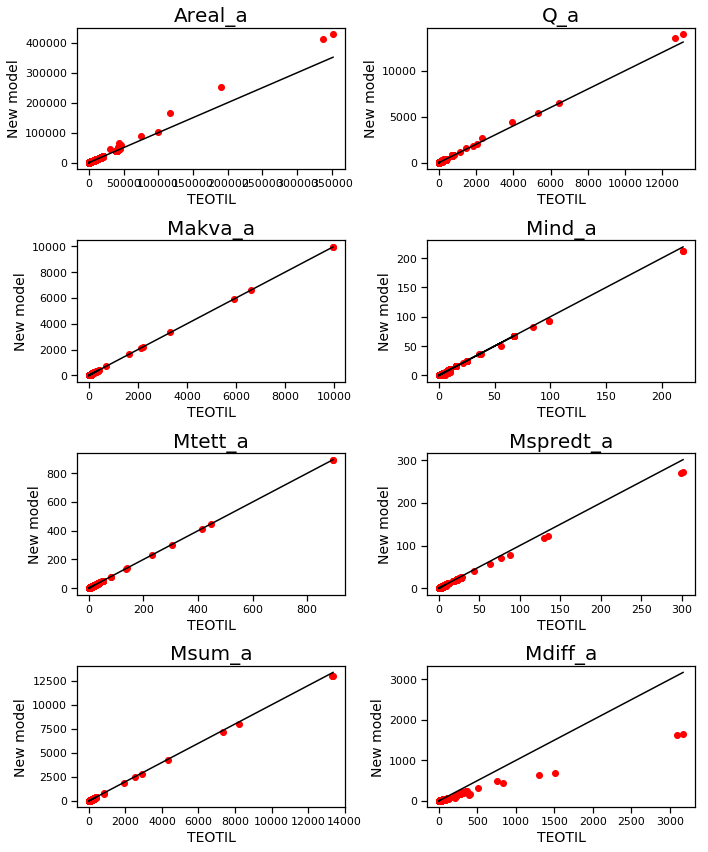

In [21]:
# Read NOPE output
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\nope_results_2015.csv')
nope_df = pd.read_csv(in_csv)

# Sum diffuse
nope_df['Mdiff_a'] = (nope_df['accum_anth_diff_tot-p_tonnes'] + 
                      nope_df['accum_nat_diff_tot-p_tonnes'])

# Get comparable cols from new model
n_cols = ['regine', 'accum_upstr_area_km2', 'accum_q_m3/s', 
          'accum_aqu_tot-p_tonnes', 'accum_ind_tot-p_tonnes', 'accum_ren_tot-p_tonnes',
          'accum_spr_tot-p_tonnes', 'accum_all_sources_tot-p_tonnes', 'Mdiff_a']

nope_df = nope_df[n_cols]

# Use same names
nope_df.columns = t_cols

# Join
df = pd.merge(nope_df, teo_ac, how='left', on='ID',
              suffixes=('_nope', '_teotil'))

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for idx, col in enumerate(t_cols[1:]):
    axes[idx].plot(df['%s_teotil' % col], df['%s_nope' % col], 'ro')
    axes[idx].plot(df['%s_teotil' % col], df['%s_teotil' % col], 'k-')
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel('TEOTIL', fontsize=14)
    axes[idx].set_ylabel('New model', fontsize=14)

plt.tight_layout()
plt.show()

C:\Data\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


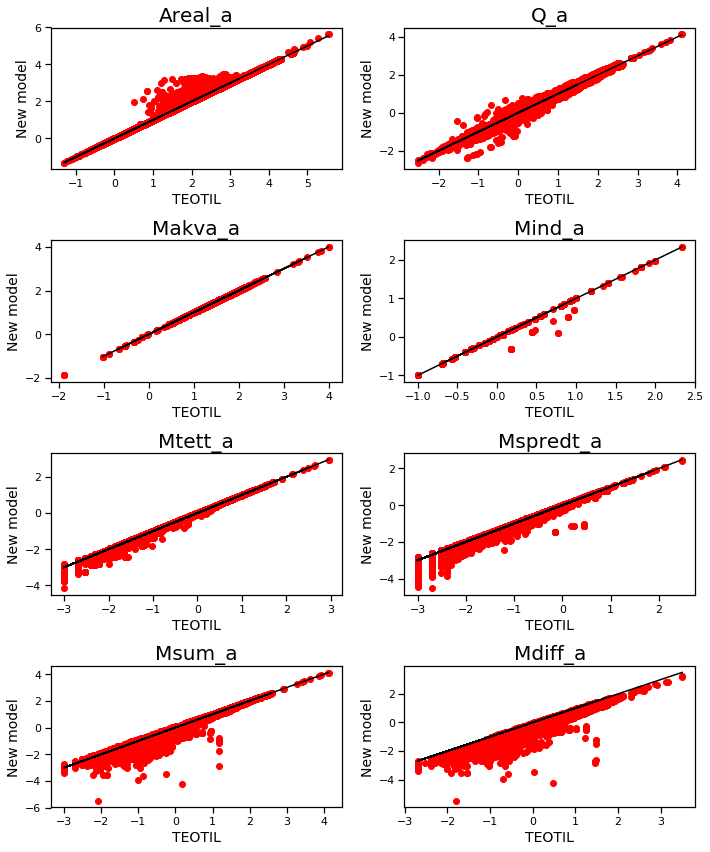

In [22]:
# Log transform
del df['ID']
df = np.log10(df)

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for idx, col in enumerate(t_cols[1:]):
    axes[idx].plot(df['%s_teotil' % col], df['%s_nope' % col], 'ro')
    axes[idx].plot(df['%s_teotil' % col], df['%s_teotil' % col], 'k-')
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel('TEOTIL', fontsize=14)
    axes[idx].set_ylabel('New model', fontsize=14)

plt.tight_layout()
plt.show()

Overall, these results are pretty similar. The main difference is that the new model generally predicts lower overall diffuse pollution loads than TEOTIL. I haven't had chance to investigate in detail yet, but I suspect this is because the two models handle retention differently. In my model, the retention factor is applied to both local and upstream sources, whereas I think TEOTIL assumes the local inputs are added at the catchment outflow, so retention only applies to upstream component (?). More precisely, if $r_i^X$ is the retention factor for pollutant $X$ in catchment $i$, $L_i^X$ is the "internal load" of nutrient $X$ added from within catchment $i$, and $I_i^X$ is the input of nutrient $X$ received from any upstream catchments, my model assumes this:
 
$$O_i^X = (1 - r_i^X) (L_i^X + I_i^X)$$
 
whereas TEOTIL assumes this:

$$O_i^X = L_i^X + I_i^X(1 - r_i^X)$$
 
If this understanding is correct, it would explain the discrepancy quite nicely: the differences become bigger as the loads increase (i.e. moving downstream), because the differences in retention accumulate.